<a href="https://colab.research.google.com/github/Ethan9123/Complete-Python-Bootcamp/blob/master/Cifar10_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR 10 image identification with Neural Networks

In [0]:
# install keras first
!pip install dill
!pip install -q keras

In [0]:
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"


In [0]:
from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("th")

Using TensorFlow backend.


In [0]:
batch_size = 256
num_classes = 10
'''
epochs_longrun = 500
save_dir = "/work"
res_dir = "/results"
model_name = 'convnet_cifar10'
'''

'\nepochs_longrun = 500\nsave_dir = "/work"\nres_dir = "/results"\nmodel_name = \'convnet_cifar10\'\n'

In [0]:
from __future__ import print_function
import tensorflow as tf
import keras
from keras.datasets import cifar10
#from keras.datasets import cifar100
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.utils import to_categorical
from keras.models import load_model

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *
import warnings
warnings.filterwarnings('ignore')

In [0]:
tf.reset_default_graph()
tf.set_random_seed(343)
np.random.seed(343)
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 3, 32, 32)
50000 train samples
10000 test samples


In [0]:
# Convert class vectors to binary class matrices.
y_train_c = to_categorical(y_train, num_classes)
y_test_c = to_categorical(y_test, num_classes)
#Normalize data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_test /= 255.0

### Prediction with Random Forest

In [0]:
#Let's see how good is RandomForest
from sklearn.ensemble import RandomForestClassifier
logit = RandomForestClassifier()
x_train_1 = x_train.reshape(x_train.shape[0],3*32*32)
x_test_1 = x_test.reshape(x_test.shape[0],3*32*32)
logit.fit(x_train_1, y_train)
print ("RandomForest Accuracy: {}%".format(logit.score(x_test_1, y_test)*100))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForest Accuracy: 36.18%


## Prediction with Feedforward Neural Networks

In [0]:
#Let's review how MLPClassifier got trained and do prediction
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100), activation='relu')
mlp.fit(x_train_1, y_train)
score =mlp.score(x_test_1, y_test)
print('MLP NN score: %.2f%%' %(score*100))

MLP NN score: 43.15%


In [0]:
# Let's see what values are in the label y_train
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

## Combining the training and test data back into one data

In [0]:
x = np.concatenate((x_train,x_test))
y = np.concatenate((y_train,y_test))
print('x shape:', x.shape)
print('y shape:', y.shape)

x shape: (60000, 3, 32, 32)
y shape: (60000, 1)


In [0]:
def cifar_grid(X,Y,inds,n_col):#print out randomly selected images and their labels
  N = len(inds)
  n_row = int(ceil(1.0*N/n_col))
  fig = plt.figure(figsize=(10, 10))
  
# align labels in the right order, i.e., from 0 to 9
  clabels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
  print(type(clabels))
  for j in range(n_row):
    for k in range(n_col):
      i_inds = (j*n_col)+k
      i_data = inds[i_inds]
      
      if i_inds < N:
        rgb = X[[i_data,...]]
        label =clabels[Y[i_data][0]]
        img = rgb.reshape(3,32,32).transpose([1, 2, 0])
        fig.add_subplot(n_row,n_col, i_inds+1)
        plt.imshow(img, interpolation='nearest')
        plt.title("{}".format(label))
        
         
  fig.set_tight_layout(True)

[35962, 52252, 27156, 30319, 57493, 24608, 33761, 20434, 47542, 19898, 39066, 33456, 50222, 51734, 41327, 4106]
<class 'list'>


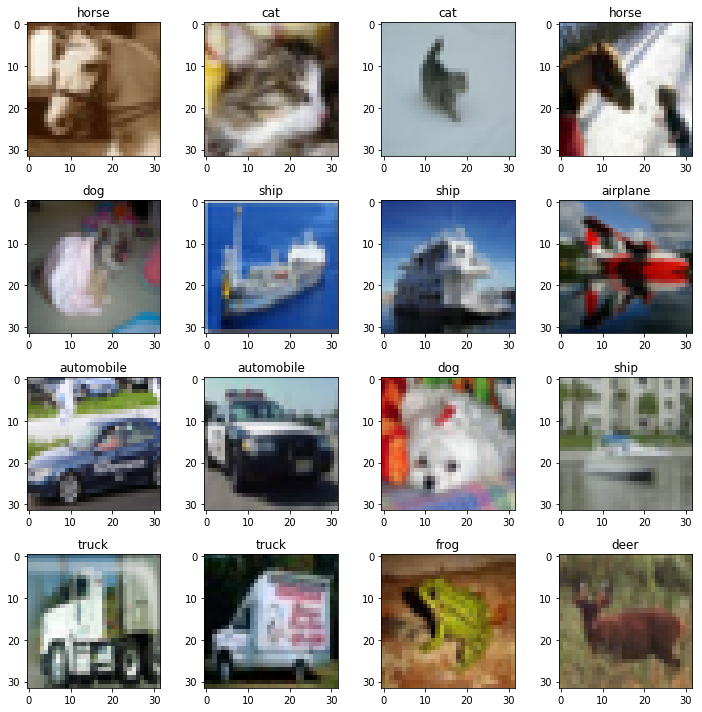

In [0]:
indices = [np.random.choice(range(len(x))) for i in range(16)]
print (indices)

cifar_grid(x,y,indices,4)

## Image identification with CNN

In [0]:
model = Sequential()

model.add(Conv2D(48, kernel_size=(3, 3), activation='relu',
                 input_shape=x_train.shape[1:]))
model.add(Conv2D(48, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(1))

model.add(Conv2D(96, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(96, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu'))


opt = Adam(lr=0.00005, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 48, 30, 30)        1344      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 48, 28, 28)        20784     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 48, 14, 14)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 48, 14, 14)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 96, 12, 12)        41568     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 96, 6, 6)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 96, 4, 4)          83040     
__________

In [0]:
print('Using real-time data augmentation.')

datagen = ImageDataGenerator(
	featurewise_center=False, 
	samplewise_center=False,  
	featurewise_std_normalization=False,
	samplewise_std_normalization=False, 
	zca_whitening=False, 
	rotation_range=0, 
	width_shift_range=0.1, 
	height_shift_range=0.1,
	horizontal_flip=True, 
	vertical_flip=False) 

datagen.fit(x_train)

Using real-time data augmentation.


In [0]:
#Let's train the model
epochs = 30
hist = model.fit_generator(datagen.flow(x_train, y_train_c,
    batch_size=batch_size,shuffle=True),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test_c),
    workers=4)

Epoch 1/30
195/195 [==============================] - 31s 160ms/step - loss: 3.3289 - acc: 0.1058 - val_loss: 2.2798 - val_acc: 0.1363
Epoch 2/30
195/195 [==============================] - 31s 157ms/step - loss: 2.3023 - acc: 0.1264 - val_loss: 2.2064 - val_acc: 0.2564
Epoch 3/30
195/195 [==============================] - 29s 150ms/step - loss: 2.1962 - acc: 0.1850 - val_loss: 2.1426 - val_acc: 0.2338
Epoch 4/30
195/195 [==============================] - 29s 147ms/step - loss: 2.1070 - acc: 0.2284 - val_loss: 1.9921 - val_acc: 0.3017
Epoch 5/30
195/195 [==============================] - 30s 155ms/step - loss: 2.2711 - acc: 0.1949 - val_loss: 2.2139 - val_acc: 0.1264
Epoch 6/30
195/195 [==============================] - 30s 155ms/step - loss: 2.1637 - acc: 0.2054 - val_loss: 2.0181 - val_acc: 0.2965
Epoch 7/30
195/195 [==============================] - 29s 150ms/step - loss: 2.0959 - acc: 0.2472 - val_loss: 1.9802 - val_acc: 0.2837
Epoch 8/30
 13/195 [=>............................] - E

KeyboardInterrupt: ignored

In [0]:
scores = model.evaluate(x_test, y_test_c, verbose=0)
print("CNN score: %.2f%%" % (scores[1]*100))

In [0]:
#print out randomly selected images(black/red labl-->correct/wrong prediction )
def cifar_grid_c(X,Y,inds,n_col, predictions=None):
  if predictions is not None:
    if Y.shape != predictions.shape:
      print("Predictions must equal Y in length!")
      return(None)
  N = len(inds)
  n_row = int(ceil(1.0*N/n_col))
  fig, axes = plt.subplots(n_row,n_col,figsize=(10,10))
  
#  clabels = labels["label_names"]
  clabels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
  print(type(clabels))
  for j in range(n_row):
    for k in range(n_col):
      i_inds = (j*n_col)+k
      i_data = inds[i_inds]
      
     # axes[j][k].set_axis_off()
      if i_inds < N:
        rgb = X[[i_data,...]]
        #print(rgb.shape)
        img = rgb.reshape(3,32,32).transpose([1, 2, 0])
        axes[j][k].imshow(img, interpolation='nearest')
        label = clabels[np.argmax(Y[i_data,...])]
        axes[j][k].set_title(label)
        if predictions is not None:
          pred = clabels[np.argmax(predictions[i_data,...])]
          if label != pred:
            label += " n"
            axes[j][k].set_title(pred, color='red')            
  
  fig.set_tight_layout(True)

In [0]:
num_predictions = 16
predict_gen = model.predict_generator(datagen.flow(x_test, y_test_c,
    batch_size=batch_size, shuffle=False),
    steps=(x_test.shape[0] // batch_size)+1, workers=4)

indices = [np.random.choice(range(len(x_test))) 
           for i in range(num_predictions)]

cifar_grid_c(x_test,y_test_c,indices,4, predictions=predict_gen)

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'test'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'test'], loc='best')
    plt.show()
plot_model_history(hist)
    


In [0]:
import dill as pickle
with open("hist_path", 'wb') as f:
    pickle.dump(hist.history, f)

In [0]:
key2name = {'acc':'Accuracy', 'loss':'Loss', 
    'val_acc':'Validation Accuracy', 'val_loss':'Validation Loss'}
with open("hist_path", 'rb') as f:
  hist = pickle.load(f)
fig = plt.figure()

things = ['acc','loss','val_acc','val_loss']
for i,thing in enumerate(things):
  trace = hist[thing]
  plt.subplot(2,2,i+1)
  plt.plot(range(len(trace)),trace)
  plt.title(key2name[thing])

fig.set_tight_layout(True)
# fig